In [167]:
import pennylane as qml
import pennylane.numpy as np
import matplotlib.pyplot as plt
import h5py
import random
import os

In [168]:
# parametros
numQubits = 4 # numero de qubits
numFeatureMaps = 1 # profundidad del mapa de caracteristicas
embedding = "amplitude" # tipo de embedding {"amplitude", "angle"}

In [ ]:
# crear la ruta del dataset
dataset_path = "../DataSet/Tumores"

# obtener todos los archivos .mat
files = [f for f in os.listdir(dataset_path) if f.endswith('.mat')]

# seleccionar un archivo aleatorio
# random.seed(7)
random_file = random.choice(files)
file_path = os.path.join(dataset_path, random_file)
print(f"Selected file: {random_file}")

# cargar la imagen
with h5py.File(file_path, 'r') as f:
    image_matrix = np.array(f['cjdata']['image'][:])

# Normalizar entre para estabilizar el circuito y los umbrales
# image_matrix = image_matrix / np.max(image_matrix) * 255

# print(f"Image shape: {image_matrix.shape}")
# print(f"Image min: {np.min(image_matrix)}, max: {np.max(image_matrix)}")

# no aplanar aqui porque quantum_conv espera la matriz 2D


Selected file: 1554.mat
Image shape: (512, 512)


In [170]:
# define the quantum device
dev = qml.device("default.qubit", wires=numQubits)

@qml.qnode(dev)
def circuit(features):
    phi = np.pi / 2 # angulo fijo para la capa de rotaciones
    if embedding == "amplitude":
        qml.AmplitudeEmbedding(features, wires=range(numQubits), normalize=True)
    elif embedding == "angle":
        qml.AngleEmbedding(features * np.pi, wires=range(numQubits), rotation='X')
    
    # Capa de Rotaciones (CRZ y CRX)
    for i in range(numQubits):
        # Define el par actual y el siguiente (circular)
        control = i
        target = (i + 1) % numQubits 

        qml.CRZ(phi, wires=[control, target])
        qml.CRX(phi, wires=[control, target])

    # Capa de Entrelazamiento (CZ)
    for i in range(numQubits):
        control = i
        target = (i + 1) % numQubits

        qml.CZ(wires=[control, target])

    # medimos el numero de qubits correspondientes a la profundidad del feature map
    return [qml.expval(qml.PauliZ(i)) for i in range(numFeatureMaps)]

In [171]:
# draw the circuit
def draw_circuit(image_vector):
    qml.drawer.use_style("black_white")
    fig, ax = qml.draw_mpl(circuit)(image_vector)
    plt.show()

In [172]:
def quantum_conv(image, numQubits, numFeatureMaps, embedding):
    # Determinar el tamaño de la ventana (kernel) basado en el embedding
    if embedding == 'angle':
        kernel_size = int(np.sqrt(numQubits))
    elif embedding == 'amplitude':
        kernel_size = int(np.sqrt(2 ** numQubits))
    else:
        raise ValueError("El tipo de embedding debe ser 'angle' o 'amplitude'")

    # El paso (stride) dinámico se ajusta al tamaño de la ventana
    stride = kernel_size
    
    # Calcular dimensiones de salida
    h, w = image.shape
    out_h = h // stride
    out_w = w // stride
    
    # Inicializar matriz para la imagen de salida
    processed_image = np.zeros((out_h, out_w, numFeatureMaps))

    # Variable para guardar un ejemplo y dibujar el circuito al final
    sample_data = None

    for i in range(out_h):
        for j in range(out_w):
            # Extraer la ventana de la imagen original
            start_y = i * stride
            start_x = j * stride
            window = image[start_y : start_y + kernel_size, start_x : start_x + kernel_size]
            
            # Aplanar la ventana para ingresarla al circuito
            data = window.flatten()

            # Procesamos el circuito
            processed_image[i, j, :] = circuit(data)
            
            # Guardamos un vector válido para dibujar luego
            if sample_data is None: 
                sample_data = data
            
            # # Usamos la media en lugar del max para ser más robustos contra picos de ruido
            # if np.mean(data) < 10: 
            #     # Asignamos -1.0 para que el fondo sea NEGRO si usamos PauliZ (rango -1 a 1)
            #     processed_image[i, j, :] = -1.0 
            # else:
            #     # Procesamos el circuito
            #     processed_image[i, j, :] = circuit(data)
            #     # Guardamos un vector válido para dibujar luego
            #     if sample_data is None: 
            #         sample_data = data

    # Dibujar el circuito
    if sample_data is not None:
        draw_circuit(sample_data)
    
    return processed_image

Starting quantum convolution... This may take a while.


c:\Users\diego\AppData\Local\Programs\Python\Python311\Lib\site-packages\pennylane\numpy\tensor.py:152: RuntimeWarning: invalid value encountered in divide
  res = super().__array_ufunc__(ufunc, method, *args, **kwargs)


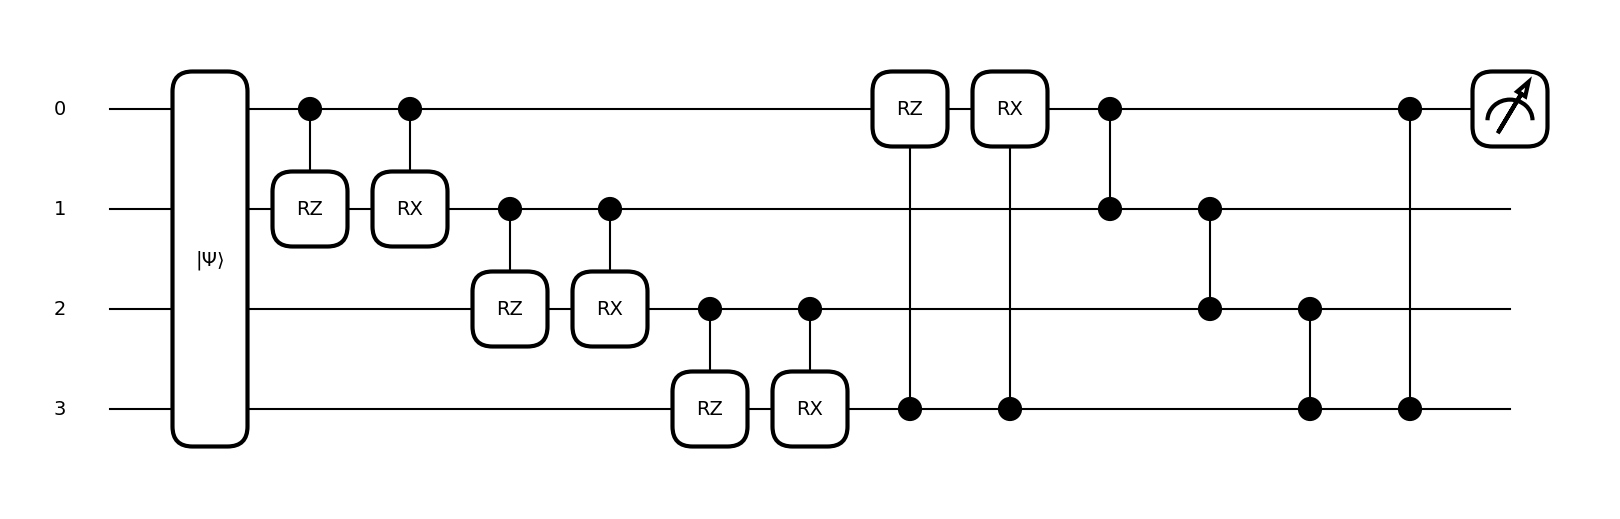

In [173]:
# Apply Quantum Convolution
print("Starting quantum convolution... This may take a while.")
convolved_image = quantum_conv(image_matrix, numQubits, numFeatureMaps, embedding)

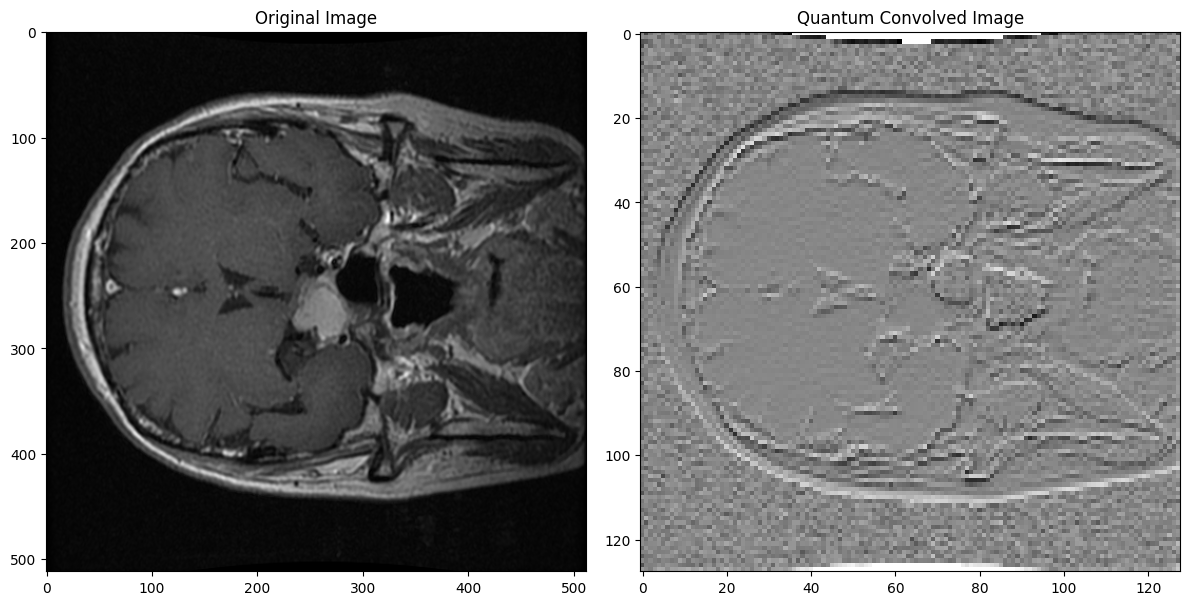

In [174]:
# Visualize Original Image
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(image_matrix, cmap='gray')
plt.title('Original Image')

# Visualize Convolved Image
plt.subplot(1, 2, 2)
plt.imshow(convolved_image[:, :, 0], cmap='gray')
plt.title('Quantum Convolved Image')
plt.tight_layout()
plt.show()